In [1]:
from dotenv import find_dotenv,load_dotenv
load_dotenv(find_dotenv())

True

In [2]:
import os,json,uuid,base64,asyncio
from io import BytesIO
from pydantic import BaseModel

from opensearchpy import OpenSearch
INDEX = os.environ['OS_INDEX']
os_client = OpenSearch(hosts=os.environ['OS_ENDPOINT'], ssl_enable=True)
mappings = os_client.indices.get_mapping(INDEX)[INDEX]['mappings']

from codeboxapi import CodeBox
from codeboxapi.schema import CodeBoxOutput
codebox = CodeBox()

from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import HumanMessage

KeyError: 'OS_INDEX'

In [20]:
top_k = 10000
# user_input = '2010年以降のレシピのうち、カロリーが高い順に100個のレシピのカロリーの散布図を描いてください。'
user_input = '2010年以降のレシピのカロリーのヒストグラムを描いてください。'

In [21]:
DSL_TEMPLATE = """\
Given an input question, create a syntactically correct Elasticsearch query to run. \
Unless the user specifies in their question a specific number of examples they wish to obtain, \
always limit your query to at most {top_k} results. \
You can order the results by a relevant column to return the most interesting examples in the database.

Unless told to do not query for all the columns from a specific index, \
only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the mapping description. \
Be careful to not query for columns that do not exist. Also, pay attention to which column is in which index. \
Return the query as valid json.

Use the following format:

Question: Question here
ESQuery: Elasticsearch Query formatted as json

Mapping: {mapping}

Question: {input}
ESQuery:
"""

In [22]:
def get_os_dsl(query,k):
    prompt = DSL_TEMPLATE.format(
        top_k=k,
        mapping=json.dumps(mappings,indent=2),
        input=query
    )
    chat = ChatOpenAI()
    messages = [HumanMessage(content=prompt)]
    response = chat(messages)
    # print(response.content)
    return response.content

In [23]:
query = get_os_dsl(user_input,top_k)

In [24]:
result = os_client.search(index=INDEX,body=json.loads(query))

In [25]:
CODE_TEMPLATE = '''\
## Input
{user_input}

## Query
{query}

## Instruction
[Input]に対して、OpenSearchで[Query]を入力し検索を行い、検索結果をresultに入力しました。
resultを用いて[Input]に対する回答を得るためのPythonコードを書いてください。
resultは入力済みの状態から開始してください。
'''

In [26]:
prompt = CODE_TEMPLATE.format(
    user_input=user_input,query=query
)

In [27]:
chat = ChatOpenAI(temperature=0.)
messages = [HumanMessage(content=prompt)]
response = chat(messages)

In [28]:
code = f'result = {json.dumps(result).replace("false","False").replace("null","None")}\n\n'+response.content

In [29]:
class File(BaseModel):
    name: str
    content: bytes

    @classmethod
    def from_path(cls, path: str):
        with open(path, "rb") as f:
            path = path.split("/")[-1]
            return cls(name=path, content=f.read())

    @classmethod
    async def afrom_path(cls, path: str):
        return await asyncio.to_thread(cls.from_path, path)

    @classmethod
    def from_url(cls, url: str):
        import requests  # type: ignore

        r = requests.get(url)
        return cls(name=url.split("/")[-1], content=r.content)

    @classmethod
    async def afrom_url(cls, url: str):
        import aiohttp

        async with aiohttp.ClientSession() as session:
            async with session.get(url) as r:
                return cls(name=url.split("/")[-1], content=await r.read())

    def save(self, path: str):
        with open(path, "wb") as f:
            f.write(self.content)

    async def asave(self, path: str):
        await asyncio.to_thread(self.save, path)

    def show_image(self):
        try:
            from PIL import Image  # type: ignore
        except ImportError:
            print(
                "Please install it with `pip install codeinterpreterapi[image_support]` to display images."
            )
            exit(1)

        from io import BytesIO

        img_io = BytesIO(self.content)
        img = Image.open(img_io)

        # Convert image to RGB if it's not
        if img.mode not in ('RGB', 'L'):  # L is for greyscale images
            img = img.convert('RGB')

        # Display the image
        try:
            # Try to get the IPython shell if available.
            shell = get_ipython().__class__.__name__  # type: ignore

            # If the shell is ZMQInteractiveShell, it means we're in a Jupyter notebook or similar.
            if shell == 'ZMQInteractiveShell':
                from IPython.display import display
                display(img)
            else:
                # We're not in a Jupyter notebook.
                img.show()
        except NameError:
            # We're probably not in an IPython environment, use PIL's show.
            img.show()

    def __str__(self):
        return self.name

    def __repr__(self):
        return f"File(name={self.name})"

In [30]:
await codebox.astart()
output: CodeBoxOutput = await codebox.arun(code)
output_files = []
# print(output.content)
if output.type == "image/png":
    filename = f"image-{uuid.uuid4()}.png"
    file_buffer = BytesIO(base64.b64decode(output.content))
    file_buffer.name = filename
    output_files.append(File(name=filename, content=file_buffer.read()))


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f4ef76836a0>


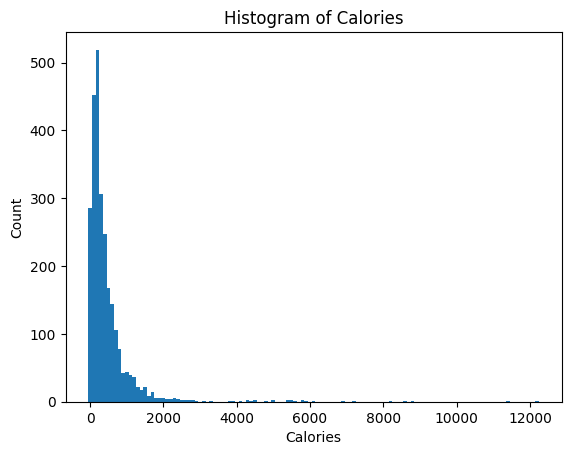

In [31]:
for f in output_files:
    f.show_image()

In [32]:
await codebox.astop()

Status(stopped)